In [109]:
from dataclasses import dataclass
from typing import Any, Callable

import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.collections
import matplotlib.lines
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from tqdm import tqdm

from plotting import label_axes
from utils import clamp_mod, gauss_cgs

In [110]:
T_UNIT = u.d
L_UNIT = u.au

def pack_t(q: u.Quantity[T_UNIT]) -> float:
    return q.to(T_UNIT).value

# Magnetic field

Uniform $B_0$ field in X direction with Alfven-wave perturbation with small amplitude $\delta B << B_0$


In [111]:
B0 = 1e-6 * gauss_cgs
deltaB = 1e-2 * B0

# plasma density
n_IMP = 1 / u.cm**3
rho_IMP = n_IMP * const.m_p
v_A = (B0 / np.sqrt(rho_IMP)).to(u.km / u.s)
print(f"v_A = {v_A:.2f} ({(v_A / const.c).decompose():.2e} * speed of light)")


@dataclass
class Particle:
    E: u.Quantity[u.eV]
    theta: u.Quantity[u.rad]

    gamma: float
    v: u.Quantity[u.km / u.s]

    R_L: u.Quantity[u.au]
    Omega_L: u.Quantity[1 / u.day]
    T_L: u.Quantity[u.day]

    k_res: u.Quantity[1 / u.au]
    w_res: u.Quantity[1 / u.kyr]
    lambda_res: u.Quantity[u.au]

    def __str__(self) -> str:
        return "\n".join(
            [
                f"proton with E = {self.E:.2f} pitch angle = {180 * self.theta.value / np.pi}",
                f"v = {self.v / const.c:.2e} c; gamma = {self.gamma:.2e}",
                f"gyration params: R = {self.R_L:.2f} T = {self.T_L:.2f}",
                f"resonance conditions: k = {self.k_res:.2e}; wavelength = {self.lambda_res:.2f}",
            ]
        )

    @classmethod
    def from_energy_pitch_angle(
        cls, E: u.Quantity[u.eV], theta: u.Quantity[u.rad] | float
    ):
        if isinstance(theta, float):
            theta = theta * u.rad
        gamma = (E / (const.m_p * const.c**2)).decompose()
        v = const.c * np.sqrt(1 - gamma ** (-2))
        R_L = (
            (gamma * const.m_p * v * np.sin(theta)) * const.c / (const.e.gauss * B0)
        ).to(u.au)
        k_res = (np.tan(theta) / R_L).to(1 / u.au)
        Omega_L = v * np.sin(theta) / R_L

        return Particle(
            E=E,
            theta=theta,
            gamma=gamma,
            v=v,
            R_L=R_L,
            Omega_L=Omega_L,
            T_L=(2 * np.pi / Omega_L).to(u.day),
            k_res=k_res,
            w_res=(k_res * v_A).to(1 / u.kyr),
            lambda_res=1 / k_res,
        )

v_A = 7.73 km / s (2.58e-05 * speed of light)


# QLT equation for pitch angle

From Lorentz force equation on $v_z = v \mu = v \cos \theta$:

$$
\frac{ d \theta }{ dt } = - \Omega \frac{\delta B}{B} \cos( \phi + \Omega t - k z(t) )
$$

We must add an equation for $z(t)$ to form a system of 2 differential equations:

$$
\frac{dz}{dt} = v \cos(\theta(t))
$$

The resulting ODE system for the vector $(\theta, z)$ is solved numerically.

In [112]:
@dataclass
class MagneticFieldPerturbationParams:
    k: u.Quantity[1 / u.pc]
    phase_diff: float


def get_theta_rhs(
    particle: Particle, mf_params: MagneticFieldPerturbationParams
) -> Callable:

    def mu_rhs(
        t: float, params: np.ndarray, pbar: tqdm | None = None, verbose: bool = False
    ) -> np.ndarray:
        if pbar is not None:
            pbar.update()
        t = t * T_UNIT
        theta, z = params
        z: u.Quantity = z * L_UNIT
        theta_dot = (
            (
                -particle.Omega_L
                * (deltaB / B0)
                * np.cos(
                    mf_params.phase_diff
                    + (particle.Omega_L * t).decompose().value
                    - (mf_params.k * z).decompose().value
                )
            )
            .to(1 / T_UNIT)
            .value
        )
        z_dot = (particle.v * np.cos(theta)).to(L_UNIT / T_UNIT).value
        result = np.array([theta_dot, z_dot])
        if verbose:
            print(f"result: {result}")
        return result

    return mu_rhs


def get_approx_theta_solution(
    particle: Particle, mf_params: MagneticFieldPerturbationParams
) -> Callable:
    omega = (particle.Omega_L - mf_params.k * particle.v * np.cos(particle.theta)).to(
        1 / T_UNIT
    )
    norm = (-particle.Omega_L * deltaB / B0).to(1 / T_UNIT)
    integration_const = (
        particle.theta - (norm / omega) * np.sin(mf_params.phase_diff) * u.rad
    ).to(u.rad).value

    def theta(t: u.Quantity[T_UNIT]) -> u.Quantity[u.rad]:
        return (
            (norm / omega).decompose() * np.sin(mf_params.phase_diff + (omega * t).decompose().value)
            + integration_const
        ) * u.rad

    return theta

In [113]:
@dataclass
class PitchAngleTrajectory:
    t: u.Quantity[u.d]
    theta: u.Quantity[u.deg]
    theta_dot: u.Quantity[u.deg / T_UNIT]
    z: u.Quantity[L_UNIT]
    z_dot: u.Quantity[L_UNIT / T_UNIT]

    particle: Particle
    mf_params: MagneticFieldPerturbationParams
    solution: Any

    description: str | None = None

    @classmethod
    def from_solution(
        cls, solution: Any, p: Particle, mf: MagneticFieldPerturbationParams
    ) -> "PitchAngleTrajectory":
        rhs = get_theta_rhs(p, mf)
        rhs_val = np.array(
            [rhs(t, params) for t, params in zip(solution.t, solution.y.T)]
        )
        return PitchAngleTrajectory(
            solution=solution,
            particle=p,
            mf_params=mf,
            t=solution.t * T_UNIT,
            theta=(180 * solution.y[0, :] / np.pi) * u.deg,
            z=solution.y[1, :] * L_UNIT,
            theta_dot=rhs_val[:, 0] * (u.rad / T_UNIT),
            z_dot=rhs_val[:, 1] * (L_UNIT / T_UNIT),
        )

    def plot_theta(self, ax: plt.Axes, **plot_kw) -> None:
        ax.plot(
            (self.t / self.particle.T_L).decompose(),
            self.theta,
            label=self.description,
            **plot_kw,
        )

    def plot_delta_z(self, ax: plt.Axes, **plot_kw) -> None:
        z_lin = self.particle.v * np.cos(self.particle.theta) * self.t
        ax.plot(
            (self.t / self.particle.T_L).decompose(),
            ((self.z - z_lin) / z_lin).decompose(),
            label=self.description,
            **plot_kw,
        )

    def plot_rhs_phase(self, ax: plt.Axes, **plot_kw) -> None:
        phase = (
            self.mf_params.phase_diff
            + (self.particle.Omega_L * self.t).decompose().value
            - (self.mf_params.k * self.z).decompose().value
        ) / np.pi
        t = (self.t / self.particle.T_L).decompose()
        wrapped, n_period = clamp_mod(phase, min=-1, period=2)
        switch_idx = np.nonzero(np.diff(n_period))[0]
        starts = np.concatenate(([0], switch_idx + 1))
        ends = np.concatenate((switch_idx + 1, [len(n_period)]))
        color = plot_kw.pop("color", None)
        for idx, (s, e) in enumerate(zip(starts, ends)):
            line, *_ = ax.plot(
                t[s:e],
                wrapped[s:e],
                label=self.description if idx == 0 else None,
                color=color,
                **plot_kw,
            )
            if color is None:
                color = line.get_color()

    def plot_phase_space(
        self,
        ax: plt.Axes,
        add_colorbar: bool = True,
        resize: bool = True,
        color: Any | None = None,
    ) -> None:
        x = self.theta.to(u.deg).value
        y = self.theta_dot.to(u.deg / u.d).value

        if color is None:
            x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
            y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))
            coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[
                :, np.newaxis, :
            ]
            coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
            coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
            segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

            lc = matplotlib.collections.LineCollection(segments)
            lc.set_array((self.t / self.particle.T_L).decompose())

            ax.add_collection(lc)
            if add_colorbar:
                plt.colorbar(lc, label="t / $T_L$")

            if resize:
                extent = 0.05
                for arr, setlim, getlim in zip(
                    (x, y), (ax.set_xlim, ax.set_ylim), (ax.get_xlim, ax.get_ylim)
                ):
                    min_ = arr.min()
                    max_ = arr.max()
                    width = max_ - min_
                    setlim(min_ - extent * width, max_ + extent * width)
        else:
            ax.plot(x, y, color=color)

        ax.axhline(0, color="k", linestyle="--", linewidth=0.5)
        ax.axvline(
            self.particle.theta.to(u.deg).value,
            color="k",
            linestyle="--",
            linewidth=0.5,
        )
        ax.set_xlabel("$ \\theta $ [deg]")
        ax.set_ylabel("$ \\dot \\theta $ [deg/day]")

In [114]:
particle = Particle.from_energy_pitch_angle(E=100 * u.GeV, theta=np.pi / 3)
print(particle)

proton with E = 100.00 GeV pitch angle = 59.99999999999999
v = 1.00e+00 c; gamma = 1.07e+02
gyration params: R = 19.31 AU T = 0.81 d
resonance conditions: k = 8.97e-02 1 / AU; wavelength = 11.15 AU


10883it [00:01, 7381.41it/s]
/Users/njvh/Documents/Science/GSSI/HEAPTH/exam/venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/njvh/Documents/Science/GSSI/HEAPTH/exam/venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/njvh/Documents/Science/GSSI/HEAPTH/exam/venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
10883it [00:01, 7681.42it/s]
/Users/njvh/Documents/Science/GSSI/HEAPTH/exam/venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in add
  result = super().__array_ufunc__(function, method, *arrays, **kwargs

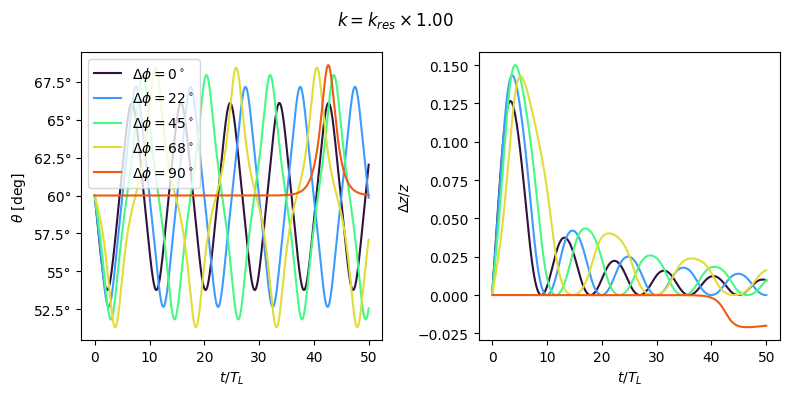

In [147]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
ax_theta = axes[0]
ax_z = axes[1]

k_mult = 1
n_T_L = 50

cmap = matplotlib.colormaps["turbo"]
phases = np.linspace(0, np.pi / 2, 5)
for idx, phase_diff in enumerate(phases):
    mf_params = MagneticFieldPerturbationParams(
        k=particle.k_res * k_mult,
        phase_diff=phase_diff,
    )
    rhs = get_theta_rhs(particle=particle, mf_params=mf_params)
    t_max = n_T_L * particle.T_L
    t_step = particle.T_L / 31
    t_eval = np.linspace(0, t_max, int(t_max / t_step))
    with tqdm() as pbar:
        solution = solve_ivp(
            fun=rhs,
            t_span=(0, pack_t(t_max)),
            y0=np.array([particle.theta.to(u.rad).value, 0]),
            t_eval=pack_t(t_eval),
            args=[pbar, False],
            method="Radau",
            max_step=pack_t(t_step),
        )
    color = cmap(idx / phases.size)
    trajectory = PitchAngleTrajectory.from_solution(solution, particle, mf_params)
    trajectory.description = f"$\\Delta \\phi = {180 * phase_diff / np.pi:.0f}^\\circ$"
    trajectory.plot_theta(ax_theta, color=color)
    approx = get_approx_theta_solution(particle, mf_params)
    ax_theta.plot(t_eval / particle.T_L, approx(t_eval), color=color, linestyle="--")
    trajectory.plot_delta_z(ax_z, color=color)

label_axes(ax_theta, "t / T_L", "\\theta")
label_axes(ax_z, "t / T_L", "\\Delta z / z")
ax_theta.legend()
fig.suptitle(f"$k = k_{{res}} \\times {k_mult:.2f}$")
plt.tight_layout()
plt.show()

10883it [00:01, 7276.06it/s]
10883it [00:01, 8317.53it/s]
10883it [00:01, 7281.59it/s]
10883it [00:01, 8413.21it/s]
10883it [00:01, 8155.02it/s]
10883it [00:01, 7960.06it/s]
10883it [00:01, 7587.41it/s]


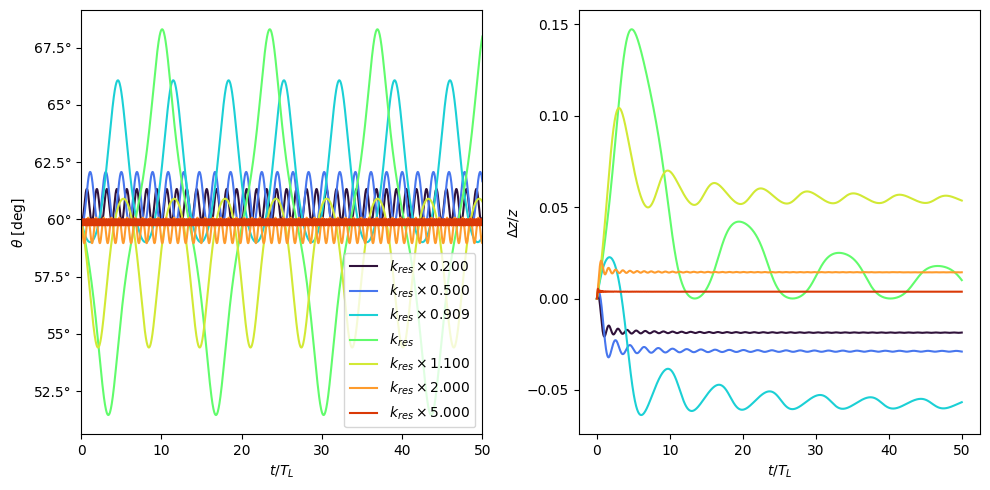

In [131]:
_, axes = plt.subplots(ncols=2, figsize=(10, 5))
ax_theta = axes[0]
ax_z = axes[1]

phase_diff = np.pi / 3
n_T_L = 50

multiplier_gt = (1.1, 2, 5)
multipliers = sorted([1 / m for m in multiplier_gt]) + [1] + sorted(multiplier_gt)
total = len(multipliers)
cmap = matplotlib.colormaps["turbo"]
trajectories: list[PitchAngleTrajectory] = []
for idx, multiplier in enumerate(multipliers):
    color = cmap(idx / total)
    mf_params = MagneticFieldPerturbationParams(
        k=particle.k_res * multiplier,
        phase_diff=phase_diff,
    )
    # hypothesis_theta_lim = np.arccos(particle.Omega_L / (mf_params.k * particle.v))
    rhs = get_theta_rhs(particle=particle, mf_params=mf_params)
    with tqdm() as pbar:
        solution = solve_ivp(
            fun=rhs,
            t_span=(0, pack_t(n_T_L * particle.T_L)),
            y0=np.array([particle.theta.to(u.rad).value, 0]),
            args=[pbar, False],
            method="Radau",
            max_step=pack_t(particle.T_L / 31),
        )
    trajectory = PitchAngleTrajectory.from_solution(solution, particle, mf_params)
    trajectory.description = (
        f"$ k_{{res}} \\times {multiplier:.3f} $" if multiplier != 1 else "$k_{res}$"
    )
    trajectories.append(trajectory)
    trajectory.plot_theta(ax_theta, color=color)
    # approx = get_approx_theta_solution(particle, mf_params)
    # ax_theta.plot(t_eval / particle.T_L, approx(t_eval), color=color, linestyle="--")
    trajectory.plot_delta_z(ax_z, color=color)

label_axes(ax_theta, "t / T_L", "\\theta")
label_axes(ax_z, "t / T_L", "\\Delta z / z")
ax_theta.set_xlim(0, n_T_L)
ax_theta.legend()
plt.tight_layout()
plt.show()

100%|██████████| 6/6 [00:45<00:00,  7.56s/it]


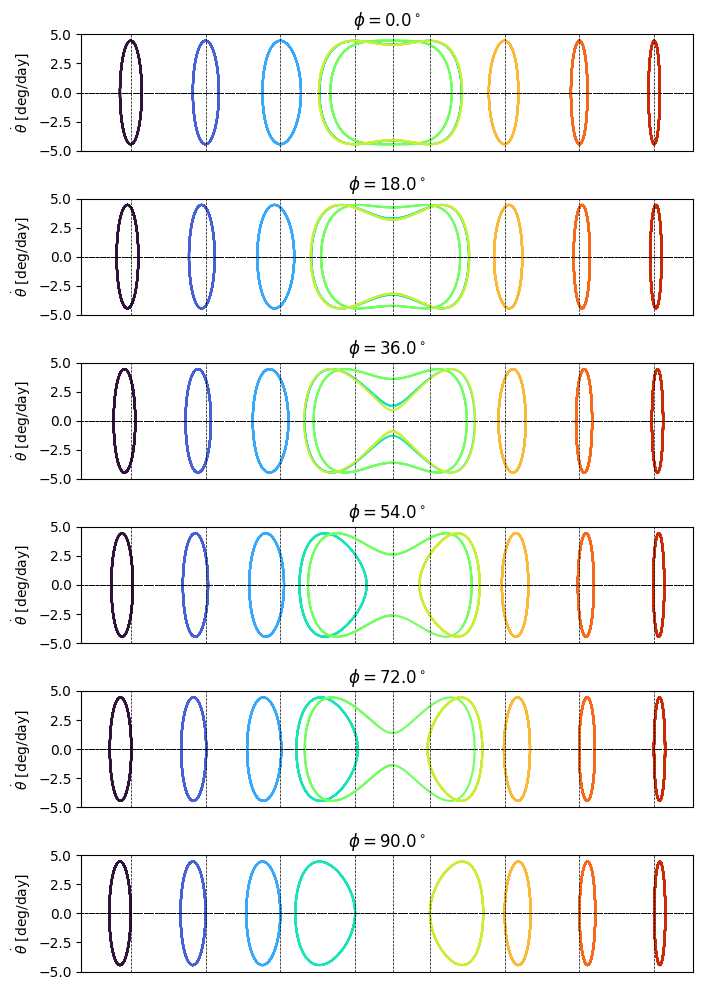

In [134]:
import itertools

_, axes = plt.subplots(figsize=(7, 10), nrows=6, sharex=True)

E = 100 * u.GeV
particle_res = Particle.from_energy_pitch_angle(E, theta=np.pi / 4)
cmap = matplotlib.colormaps["turbo"]

for phase_diff, ax in zip(tqdm(np.linspace(0, np.pi / 2, len(axes))), axes):
    mf_params = MagneticFieldPerturbationParams(
        k=particle_res.k_res,
        phase_diff=phase_diff,
    )

    n_T_L = 30

    thetas = sorted(
        itertools.chain(
            np.linspace(0, np.pi / 2, 10)[1:-1],
            [particle_res.theta.value],
        )
    )
    for idx, theta in enumerate(thetas):
        particle_ = Particle.from_energy_pitch_angle(E, theta=theta)
        rhs = get_theta_rhs(particle=particle_, mf_params=mf_params)
        solution = solve_ivp(
            fun=rhs,
            t_span=(0, pack_t(n_T_L * particle_.T_L)),
            y0=np.array([particle_.theta.to(u.rad).value, 0]),
            method="Radau",
            max_step=pack_t(particle_.T_L / 31),
        )
        PitchAngleTrajectory.from_solution(
            solution, particle_, mf_params
        ).plot_phase_space(ax, color=cmap(idx / len(thetas)))
        if idx + 1 < len(thetas):
            ax.get_xaxis().set_visible(False)

    ax.set_ylim(-5, 5)
    ax.set_title(f"$ \\phi = {180 * phase_diff / np.pi :.1f}^\\circ $")

fig.suptitle(f"$ k = k_{{res}}({particle_res.theta.to(u.deg).value:.0f}^\\circ) $")
plt.tight_layout()
plt.show()

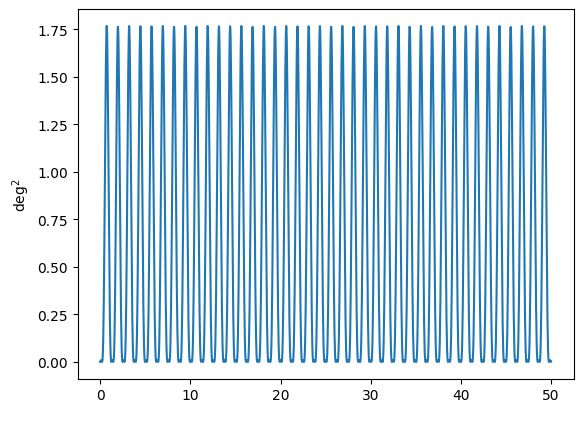

In [146]:
traj = trajectories[0]
# traj = trajectories[len(trajectories) // 2]

dtheta = traj.theta - traj.particle.theta

_, ax = plt.subplots()
def Dtheta(traj: PitchAngleTrajectory) -> u.Quantity[u.deg**2 / u.]:
    t_step = traj.t[1] - traj.t[0]
    T = traj.t[-1] - traj.t[0]
    return (dtheta ** 2).sum() * t_step / T

ax.plot(traj.t / traj.particle.T_L, dtheta**2)